In [1]:
import torch
import numpy as np
from torchvision.io import image as torch_image
import cv2
import pathlib
import torchvision
from scipy.ndimage.measurements import label
from PIL.Image import Image, open as im_open
import PIL.Image

/tmp/ipykernel_918810/4200020444.py:7: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [2]:
def remove_noise(mask, kernel_size=3, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=iterations)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=iterations)
    return closing


In [3]:
def mask_to_bboxes(mask, threshold=0.5, remove_noise_flag=True):
    if remove_noise_flag:
        mask = remove_noise(mask)

    # Apply threshold to create a binary mask
    binary_mask = mask

    # Label connected components
    labeled_array, num_features = label(binary_mask)

    bboxes = []
    for i in range(1, num_features + 1):
        # Get the individual component mask
        component_mask = (labeled_array == i)

        # Find the coordinates of the bounding box
        y_coords, x_coords = np.where(component_mask)
        x_min, x_max = x_coords.min(), x_coords.max()
        y_min, y_max = y_coords.min(), y_coords.max()

        bboxes.append([x_min, y_min, x_max, y_max])

    return bboxes


In [4]:
pred_dir = pathlib.Path("/home/fummicc1/codes/signate/") / "test" / "old" / "predicted"

In [5]:
CLASS_MAP = {  
  0: "0_background",
  1: "2_handwritten",
  2: "3_typography",
  3: "4_illustration",
  4: "5_stamp",
  5: "6_headline",
  6: "7_caption",
  7: "8_textline",
}

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), array([1506154,     325,    2923,  410271,     972,     271,   18053,
          2926,      23,     702,    2980]))
(1216, 1600)


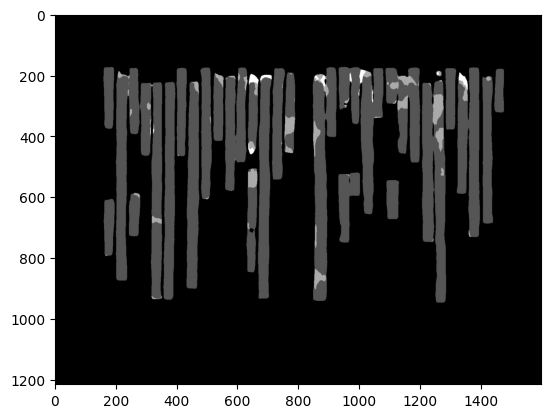

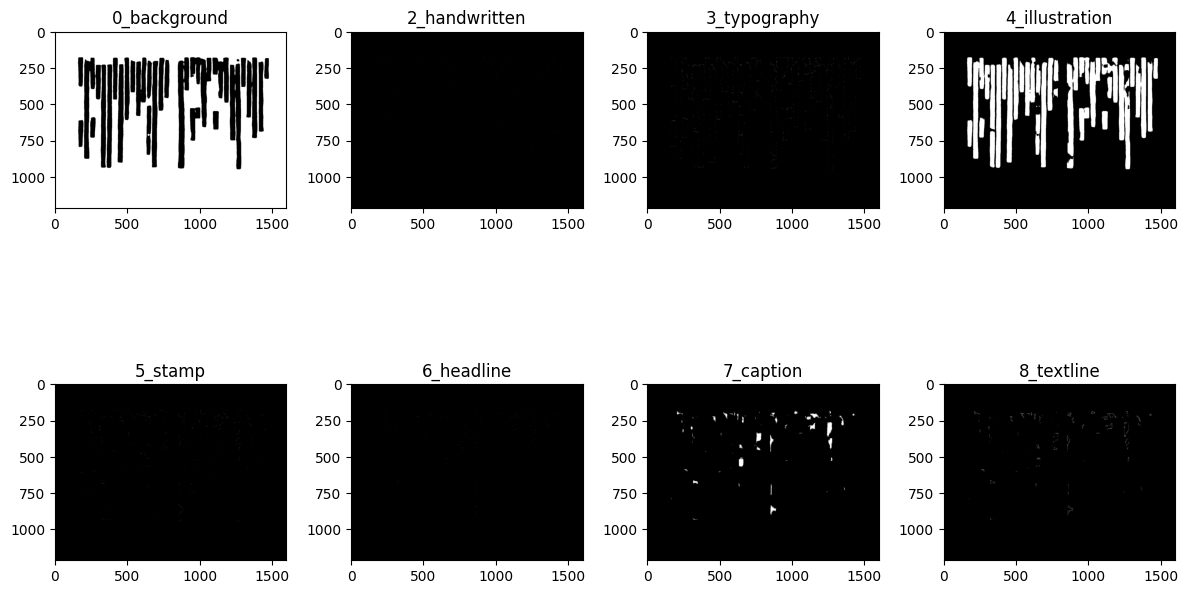

In [27]:
import math
import matplotlib.pyplot as plt
import random

pred_dirs = list(pred_dir.iterdir())
random.shuffle(pred_dirs)
for pred_path in pred_dirs:
    # print(pred_path.as_posix())
    pred = cv2.imread(pred_path.as_posix())
    plt.imshow(pred)    
    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
    pred = np.floor(pred / 25)
    pred = np.array(pred)
    print(np.unique(pred, return_counts=True))
    print(pred.shape)
    
    fig, ax = plt.subplots(ncols=4, nrows=math.ceil(len(CLASS_MAP) / 4))
    fig.set_size_inches(12, 8)
    
    for index, key in CLASS_MAP.items():        
        img = pred.copy()
        sub = ax[index // 4][index % 4]
        pred_pil = (pred == index) * 25
        sub.imshow(pred_pil, cmap="gray") 
        sub.set_title(key)
        
        # Convert the segmentation mask to bounding boxes
        bboxes = mask_to_bboxes(img, remove_noise_flag=False)

        # print("Bounding boxes:", bboxes)
        
    fig.tight_layout()
    break